In [1]:
from IPython.display import display, Image, SVG
from keras.models import load_model

def loadModel(modelPath):
    """
    Loads the model `modelPath`.
    """
    model = load_model(modelPath)
    return model

Using TensorFlow backend.


In [2]:
def getLayerConfig(layer):
    """
    Extract configuration from `layer`.
    """
    layerType = layer.__class__.__name__
    output = { 'type': layerType }
    config = layer.get_config()
    if layerType == 'Lambda':
        _, x, y, d = config['batch_input_shape']
        output['input'] = (x, y, d)
    if layerType == 'Cropping2D':
        output['cropping'] = config['cropping']
    if layerType == 'Convolution2D':
        output['activation'] = config['activation']
        output['strides'] = config['subsample']
        output['filters'] = config['nb_filter']
        output['kernel'] = ( config['nb_col'], config['nb_row'] )
    if layerType == 'Dense':
        output['activation'] = config['activation']
        output['output'] = config['output_dim']
        output['input'] = config['input_dim']
    return output

from functools import reduce
def compressLayers(layers):
    """
    Compress the common layers into a single structure for visualization.
    """
    def reductor(acc, layer):
        if len(acc) == 0:
            acc.append(layer)
            return acc
        
        last = acc[-1]
        if last['type'] == layer['type']:
            try:
                last['items'].append(layer)
            except KeyError:
                acc[-1] = { 'type': layer['type'], 'items': [last, layer]}
        else:
            acc.append(layer)
        return acc
    
    return reduce(reductor, layers, [])

In [3]:
import graphviz as gv
import functools
import json

In [4]:
def createNode(nodeName, layer, g, style='filled', fillcolor='white', fontcolor='black'):
    """
    Creates a node with the information from `layer` in the `g`.
    """
    type = layer['type']
    label = type + '\n'
    for key, value in layer.items():
        if (key != 'type'):
            label += '{}: {}\n'.format(key, value)
    g.node(nodeName, label=label, style=style, fillcolor=fillcolor, fontcolor=fontcolor)

def visualizeLayers(layers, outputPath):
    """
    Visualize `layers` and store the image at `outputPath`.
    """
    fillcolors = { 'Convolution2D':'#AAAAAA', 'Dense':'#006699' }
    g = gv.Digraph(format='png')
    for index, layer in enumerate(layers):
        nodeName = str(index)
        try:
            items = layer['items']
            subGraphType = layer['type']
            fillcolor = fillcolors[subGraphType]
            g.node(nodeName, label=subGraphType, style='filled', fillcolor=fillcolor, fontcolor='white')
            subG = gv.Digraph(format='png')
            for i, subLayer in enumerate(items):
                subNodeName = nodeName + str(i)
                createNode(subNodeName, subLayer, subG, fillcolor=fillcolor, fontcolor='white')
                if i != 0:
                    subG.edge(nodeName + str(i - 1), subNodeName)
                    
            g.subgraph(subG)
            
        except KeyError:
            createNode(nodeName, layer, g)
        if index != 0:
            g.edge(str(index - 1), nodeName)
            
    styles = {
        'graph': {
        },
        'nodes': {
            'fontname': 'Helvetica',
            'shape': 'rectangle'
        },
        'edges': {
            'arrowhead': 'open'
        }
    }
    g.graph_attr.update(
        ('graph' in styles and styles['graph']) or {}
    )
    g.node_attr.update(
        ('nodes' in styles and styles['nodes']) or {}
    )
    g.edge_attr.update(
        ('edges' in styles and styles['edges']) or {}
    )
    
    g.render(outputPath)
    figure = Image(outputPath + '.png')
    display(figure)

In [5]:
def visualizeModel(modelPath, imagePath):
    """
    Visualize the model found at `modelPath` to a SVG at `imagePath`
    """
    model = loadModel(modelPath)
    layerData = list(map(getLayerConfig, model.layers))
    compressedLayers = compressLayers(layerData)
    visualizeLayers(compressedLayers, imagePath)

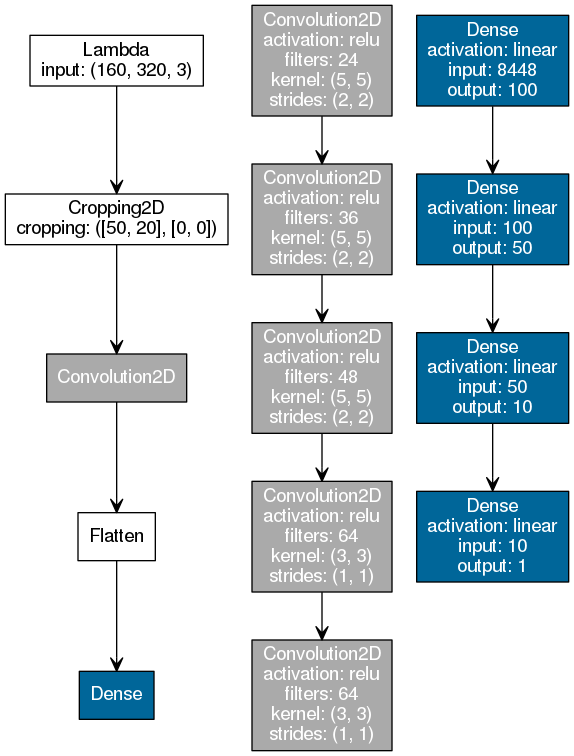

In [6]:
visualizeModel('model.h5', 'images/model')

In [7]:
loadModel('model.h5').summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

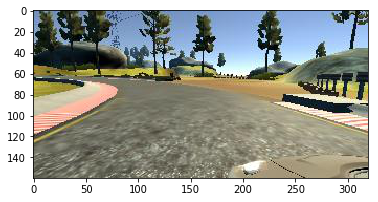

In [9]:
image2 = mpimg.imread('data/IMG/left_2016_12_01_13_31_13_584.jpg')
plt.imshow(image2)

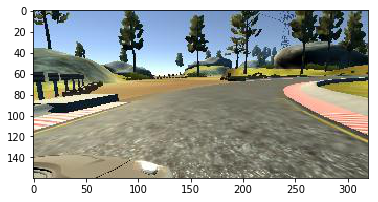

In [10]:
image2 = mpimg.imread('data/IMG/left_2016_12_01_13_31_13_584.jpg')
plt.imshow(cv2.flip(image2,1))